# Levenshtein distance and spelling corrections

The task introduces the Levenshtein distance - a measure that is useful in tasks such as approximate string matching.

In [1]:
!pip install elasticsearch==7.10.1
!pip install morfeusz2
!pip install spacy
!pip install levenshtein

In [36]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from elasticsearch.exceptions import NotFoundError
import os
import numpy as np
from tqdm import tqdm
import sys
from time import sleep
import re
from morfeusz2 import Morfeusz
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
from collections import Counter
import pylab
import matplotlib.pyplot as plt
import random
import Levenshtein
import functools
import time

## Define an ES index for storing the contents of the legislative acts (copied from previous task)

In [3]:
es = Elasticsearch()

In [4]:
es.indices.delete('my_index')

{'acknowledged': True}

In [5]:
 es.indices.create(
        index="my_index",
        body={
            "settings": {
                "analysis": {
                    "analyzer": {
                        "default": {
                            "type": "custom",
                            "tokenizer": "standard",
                            "filter": [
                                "nlp_synonyms",
                                "morfologik_stem",
                                "lowercase",
                            ]
                        }
                    },
                    "filter": {
                        "nlp_synonyms": {
                            "type": "synonym",
                            "synonyms": [
                                "kpk,kodeks postępowania karnego",
                                "kpc,kodeks postępowania cywilnego",
                                "kk,kodeks karny",
                                "kc,kodeks cywilny",
                            ]
                        }
                    }
                }
            },
        }
    )

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'}

## Load the data to the ES index

In [6]:
ustawy_path = '../ustawy'

In [7]:
contain_html = False
content = ''
with tqdm(total=1179, file=sys.stdout) as pbar:        
    for filename in os.listdir(ustawy_path):
        with open(ustawy_path + '/' + filename, 'r', encoding='utf8') as f:
            content = f.read()
            if re.search('<\/?\w+>', content) is not None:
                contain_html = True
            body = {"content": content}
            es.create(index="my_index", id=filename, body=body)
            pbar.update(1)
sleep(3)                

100%|██████████████████████████████████████████████████████████████████████████████| 1179/1179 [00:29<00:00, 40.22it/s]


## Make sure the texts in the corpus does not contain HTML code.

In [8]:
assert(not contain_html)

## Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus.

In [9]:
nlp = Polish()
tokenizer = nlp.tokenizer

## Compute frequency list for each of the processed files.

In [10]:
tokens_map = {}

with tqdm(total=1179, file=sys.stdout) as pbar: 
    for filename in os.listdir(ustawy_path):
            with open(ustawy_path + '/' + filename, 'r', encoding='utf8') as f:
                content = f.read()
                tokens = [token.text for token in tokenizer(content)]
                tokens_map[filename] = Counter(tokens)
                pbar.update(1)


100%|██████████████████████████████████████████████████████████████████████████████| 1179/1179 [00:29<00:00, 39.55it/s]


In [11]:
tokens_map['1993_599.txt']

Counter({'\n\n\n\n': 1,
         'Dz': 4,
         '.': 497,
         'U': 4,
         'z': 106,
         '1993': 9,
         'r': 20,
         'Nr': 11,
         '129': 2,
         ',': 306,
         'poz': 17,
         '599': 2,
         '\n                                ': 3,
         'USTAWA': 1,
         '\n                        ': 2,
         'dnia': 12,
         '9': 9,
         'grudnia': 9,
         '\n                                    \n             ': 1,
         'o': 41,
         'zmianie': 1,
         'ustawy': 10,
         'podatku': 42,
         'od': 28,
         'towarów': 49,
         'i': 150,
         'usług': 29,
         'oraz': 30,
         'akcyzowym': 4,
         '\n                                    \n                                    \n                                ': 1,
         'Art': 8,
         '1': 94,
         '\n': 561,
         'W': 12,
         'ustawie': 1,
         '8': 10,
         'stycznia': 2,
         '(': 48,
         '11': 13,
    

## Aggregate the result to obtain one global frequency list.

In [12]:
total_counter = Counter()

for _, counter in tokens_map.items():
    total_counter += counter

In [13]:
total_counter

Counter({'\n\n\n\n': 842,
         'Dz': 8884,
         '.': 437694,
         'U': 8320,
         'z': 81531,
         '1993': 804,
         'r': 33052,
         'Nr': 43418,
         '129': 268,
         ',': 341126,
         'poz': 45203,
         '599': 40,
         '\n                                ': 1630,
         'USTAWA': 999,
         '\n                        ': 231,
         'dnia': 17937,
         '9': 5118,
         'grudnia': 2117,
         '\n                                    \n             ': 12,
         'o': 64169,
         'zmianie': 1518,
         'ustawy': 13067,
         'podatku': 2046,
         'od': 16032,
         'towarów': 1916,
         'i': 89314,
         'usług': 1609,
         'oraz': 33552,
         'akcyzowym': 90,
         '\n                                    \n                                    \n                                ': 151,
         'Art': 30838,
         '1': 73108,
         '\n': 181703,
         'W': 13715,
         'ustawie': 

## Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).

In [14]:
for key, cnts in list(total_counter.items()):
    if len(key) < 2 or not key.isalpha():
        del total_counter[key]

In [15]:
total_counter_list = total_counter.most_common()
numbers = list(map(lambda x: x[1], total_counter_list))
highest_rank_words = list(map(lambda x: x[0], total_counter_list))
total_counter_list

[('do', 57269),
 ('ust', 53631),
 ('art', 52961),
 ('na', 49421),
 ('się', 45882),
 ('lub', 45800),
 ('poz', 45203),
 ('Nr', 43418),
 ('oraz', 33552),
 ('Art', 30838),
 ('mowa', 28780),
 ('nie', 22345),
 ('przez', 20731),
 ('pkt', 19124),
 ('dnia', 17937),
 ('których', 17928),
 ('od', 16032),
 ('jest', 13193),
 ('ustawy', 13067),
 ('po', 12991),
 ('może', 12076),
 ('którym', 11787),
 ('brzmienie', 10576),
 ('za', 10328),
 ('otrzymuje', 9835),
 ('spraw', 9034),
 ('Dz', 8884),
 ('albo', 8708),
 ('dodaje', 8423),
 ('ich', 8196),
 ('jeżeli', 7802),
 ('dla', 7727),
 ('której', 7476),
 ('brzmieniu', 7295),
 ('drodze', 7179),
 ('pracy', 6957),
 ('podstawie', 6849),
 ('stosuje', 6674),
 ('przypadku', 6494),
 ('niż', 6451),
 ('tym', 6366),
 ('jego', 6320),
 ('Minister', 6202),
 ('są', 6155),
 ('być', 6119),
 ('zakresie', 6098),
 ('właściwy', 5936),
 ('wyrazy', 5816),
 ('ustawie', 5473),
 ('ze', 5452),
 ('także', 5445),
 ('rozporządzenia', 5313),
 ('tych', 5048),
 ('określonych', 5043),
 ('przep

## Make a plot in a logarithmic scale (for X and Y):

    - X-axis should contain the rank of a term, meaning the first rank belongs to the term with the highest number of occurrences; the terms with the same number of occurrences should be ordered by their name,
    - Y-axis should contain the number of occurrences of the term with given rank.


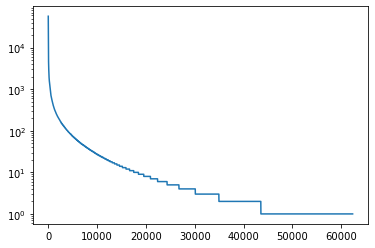

In [16]:
plt.yscale("log")
plt.plot(numbers)

## Install Morfeusz (Binding dla Pythona) and use it to find all words that do not appear in that dictionary.

In [17]:
morf = Morfeusz()

In [18]:
words_not_in_morf_counter = list(filter(lambda w: morf.analyse(w[0])[0][2][2] == "ign", total_counter_list))
words_in_morf_counter = list(filter(lambda w: morf.analyse(w[0])[0][2][2] != "ign", total_counter_list))
words_not_in_morf_counter

[('poz', 45203),
 ('późn', 1065),
 ('str', 516),
 ('GMO', 298),
 ('SWW', 216),
 ('operacyjno', 209),
 ('SKW', 196),
 ('zm', 192),
 ('ex', 167),
 ('IKE', 162),
 ('rolno', 160),
 ('techniczno', 122),
 ('remediacji', 120),
 ('rozdz', 102),
 ('URE', 101),
 ('UKE', 97),
 ('itp', 96),
 ('kN', 95),
 ('charytatywno', 87),
 ('sanitarno', 84),
 ('CN', 83),
 ('PKWiU', 81),
 ('UDT', 77),
 ('społeczno', 73),
 ('np', 71),
 ('BSWSG', 70),
 ('BSWP', 66),
 ('Społeczno', 64),
 ('organizacyjno', 55),
 ('Biobójczych', 55),
 ('PHS', 53),
 ('komandytowo', 51),
 ('wodociągowo', 47),
 ('architektoniczno', 44),
 ('HCFC', 44),
 ('adopcyjno', 42),
 ('FEP', 42),
 ('dyplomatyczno', 41),
 ('MgO', 41),
 ('UTK', 40),
 ('emerytalno', 39),
 ('FRD', 36),
 ('RON', 35),
 ('UOKiK', 35),
 ('Rolno', 34),
 ('DOKE', 34),
 ('CBŚP', 34),
 ('PCN', 32),
 ('vitro', 32),
 ('HACCP', 32),
 ('ITS', 31),
 ('kontrolno', 30),
 ('metylo', 30),
 ('inulinowego', 29),
 ('EFRROW', 28),
 ('fenylo', 28),
 ('diagnostyczno', 27),
 ('PCB', 26),
 ('

## Find 30 words with the highest ranks that do not belong to the dictionary.

In [19]:
words_not_in_morf = list(filter(lambda x: x[0], words_not_in_morf_counter[:30]))
words_not_in_morf_counter[:30]

[('poz', 45203),
 ('późn', 1065),
 ('str', 516),
 ('GMO', 298),
 ('SWW', 216),
 ('operacyjno', 209),
 ('SKW', 196),
 ('zm', 192),
 ('ex', 167),
 ('IKE', 162),
 ('rolno', 160),
 ('techniczno', 122),
 ('remediacji', 120),
 ('rozdz', 102),
 ('URE', 101),
 ('UKE', 97),
 ('itp', 96),
 ('kN', 95),
 ('charytatywno', 87),
 ('sanitarno', 84),
 ('CN', 83),
 ('PKWiU', 81),
 ('UDT', 77),
 ('społeczno', 73),
 ('np', 71),
 ('BSWSG', 70),
 ('BSWP', 66),
 ('Społeczno', 64),
 ('organizacyjno', 55),
 ('Biobójczych', 55)]

## Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [20]:
random.shuffle(words_not_in_morf_counter)

In [21]:
random_words_5_occ = []

for word, count in words_not_in_morf_counter:
    if count == 5:
        random_words_5_occ.append(word)
    if len(random_words_5_occ) == 30:
        break
        
random_words_5_occ        

['informacyjno',
 'remediację',
 'RR',
 'denitracyjne',
 'geodezyjno',
 'ym',
 'ppkt',
 'difenylopropylo',
 'EudraVigilance',
 'organicz',
 'Betezda',
 'ośc',
 'nym',
 'próbobiorców',
 'kJ',
 'tów',
 'inspekcyjno',
 'winopochodne',
 'vista',
 'Agave',
 'URT',
 'ami',
 'rialnego',
 'Avian',
 'instrumen',
 'KPWiG',
 'teryto',
 'RCI',
 'sposb',
 'heptanol']

## Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from lists defined in two previous points.

In [40]:
def print_did_you_mean(words):
    start = time.time()
    for word in words:
        i = 0
        found = False
        while(not found):
            i += 1
            for dict_word, _ in words_in_morf_counter:
                if Levenshtein.distance(word, dict_word) == i:
                    print("'"+word+"'", ": Did you mean", "'"+dict_word+"'?")
                    found = True
                    break  
    end = time.time()                
    print()
    print("took",end-start,"s")

In [41]:
print_did_you_mean(list(map(lambda x: x[0], words_not_in_morf)))

'poz' : Did you mean 'po'?
'późn' : Did you mean 'plan'?
'str' : Did you mean 'st'?
'GMO' : Did you mean 'IMO'?
'SWW' : Did you mean 'Sąd'?
'operacyjno' : Did you mean 'operacyjne'?
'SKW' : Did you mean 'Sąd'?
'zm' : Did you mean 'za'?
'ex' : Did you mean 'ej'?
'IKE' : Did you mean 'II'?
'rolno' : Did you mean 'rolne'?
'techniczno' : Did you mean 'techniczne'?
'remediacji' : Did you mean 'mediacji'?
'rozdz' : Did you mean 'rozkaz'?
'URE' : Did you mean 'UE'?
'UKE' : Did you mean 'UE'?
'itp' : Did you mean 'ity'?
'kN' : Did you mean 'kg'?
'charytatywno' : Did you mean 'charytatywną'?
'sanitarno' : Did you mean 'sanitarny'?
'CN' : Did you mean 'Co'?
'PKWiU' : Did you mean 'PKP'?
'UDT' : Did you mean 'UST'?
'społeczno' : Did you mean 'społeczne'?
'np' : Did you mean 'na'?
'BSWSG' : Did you mean 'EWG'?
'BSWP' : Did you mean 'BSE'?
'Społeczno' : Did you mean 'Społeczna'?
'organizacyjno' : Did you mean 'organizacyjne'?
'Biobójczych' : Did you mean 'roboczych'?

took 0.5719869136810303 s


In [42]:
print_did_you_mean(random_words_5_occ)

'informacyjno' : Did you mean 'informacyjne'?
'remediację' : Did you mean 'mediację'?
'RR' : Did you mean 'NR'?
'denitracyjne' : Did you mean 'dekoracyjne'?
'geodezyjno' : Did you mean 'geodezyjne'?
'ym' : Did you mean 'tym'?
'ppkt' : Did you mean 'pkt'?
'difenylopropylo' : Did you mean 'difenyle'?
'EudraVigilance' : Did you mean 'udzielanie'?
'organicz' : Did you mean 'organach'?
'Betezda' : Did you mean 'Betel'?
'ośc' : Did you mean 'oś'?
'nym' : Did you mean 'tym'?
'próbobiorców' : Did you mean 'pracobiorcą'?
'kJ' : Did you mean 'kg'?
'tów' : Did you mean 'rów'?
'inspekcyjno' : Did you mean 'inspekcyjny'?
'winopochodne' : Did you mean 'krwiopochodne'?
'vista' : Did you mean 'lista'?
'Agave' : Did you mean 'Agape'?
'URT' : Did you mean 'ART'?
'ami' : Did you mean 'ani'?
'rialnego' : Did you mean 'realnego'?
'Avian' : Did you mean 'zmian'?
'instrumen' : Did you mean 'instrument'?
'KPWiG' : Did you mean 'EWG'?
'teryto' : Did you mean 'tery'?
'RCI' : Did you mean 'II'?
'sposb' : Did you

## Load SGJP dictionary (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) and use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [165]:
es.indices.delete('sgjp')

{'acknowledged': True}

In [166]:
 es.indices.create(
        index="sgjp"
    )

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'sgjp'}

In [167]:
def insert_sgjp_to_es(filename):
    with open(filename, encoding='utf-8') as f:
        for line in f:
            if len(line.split()) != 4:
                continue
            else:
                yield {
                    "_index": "sgjp",
                    "word": line.split()[0],
                }
                break
        for line in f:
            yield {
                "_index": "sgjp",
                "word": line.split()[0],
            }

helpers.bulk(es, insert_sgjp_to_es("sgjp-20211114.tab"), chunk_size=100000, request_timeout=6000)

(7409492, [])

In [46]:
took = 0
for word in random_words_5_occ:
    global took
    response = es.search(
                index="sgjp", 
                body={
                    "query": {
                        "fuzzy": {
                            "word": {
                                "value": word,
                                "fuzziness": 10
                            }
                        }
                    }
                })
    if len(response['hits']['hits']) > 0:
        print("'"+word+"'", ": Did you mean", "'"+response['hits']['hits'][0]['_source']['word']+"'?")
    else:
        print("-> not found correction for:",word)
    took += response['took']    
print()
print("took",took,"ms")

'informacyjno' : Did you mean 'informacyjno'?
'remediację' : Did you mean 'repudiację'?
'RR' : Did you mean 'CB-radia'?
'denitracyjne' : Did you mean 'defibracyjne'?
'geodezyjno' : Did you mean 'geodezyjno'?
'ym' : Did you mean 'DM-em'?
'ppkt' : Did you mean 'pakt'?
-> not found correction for: difenylopropylo
-> not found correction for: EudraVigilance
'organicz' : Did you mean 'ogranicz'?
'Betezda' : Did you mean 'etezja'?
'ośc' : Did you mean 'Owc'?
'nym' : Did you mean 'Cym'?
'próbobiorców' : Did you mean 'pracobiorców'?
'kJ' : Did you mean 'ko-ko-ko'?
'tów' : Did you mean 'Otów'?
'inspekcyjno' : Did you mean 'inspekcyjno'?
-> not found correction for: winopochodne
'vista' : Did you mean 'lista'?
'Agave' : Did you mean 'agape'?
-> not found correction for: URT
'ami' : Did you mean 'AM-ami'?
'rialnego' : Did you mean 'realnego'?
'Avian' : Did you mean 'Lnian'?
'instrumen' : Did you mean 'instrument'?
-> not found correction for: KPWiG
'teryto' : Did you mean 'teryno'?
-> not found c

## The number of true misspellings vs. the number of unknown words.

In [26]:
count = 0.0

for word, _ in words_not_in_morf_counter:
    response = es.search(
                index="sgjp", 
                body={
                    "query": {
                        "fuzzy": {
                            "word": {
                                "value": word,
                                "fuzziness": 10
                            }
                        }
                    }
                })
    if len(response['hits']['hits']) == 0:
        count += 1.0

In [27]:
print("unknown words", count / len(words_not_in_morf_counter) * 100, "%")
print("true misspelings", 100 - count / len(words_not_in_morf_counter) * 100, "%")

unknown words 36.28005657708628 %
true misspelings 63.71994342291372 %


## The performance of your method compared to ElasticSearch.

In [35]:
took = 0
body = {"fields": ["content"],"term_statistics": True,"field_statistics": True}
def get_term_freq(id: str):
    global took
    x = es.termvectors(index="my_index", id=id, body=body)
    took += x['took']
    return Counter(dict([(k, v["term_freq"]) for k,v in x["term_vectors"]["content"]["terms"].items() if not re.match(r'\d+', k)]))

term_freq = functools.reduce(lambda x,y : x + y, [get_term_freq(f_id) for f_id in os.listdir(ustawy_path)])
print("took:",took,"ms")

took: 14509 ms


In [30]:
term_freq

Counter({'a': 16997,
         'akcesoria': 11,
         'akcesorium': 11,
         'akcyza': 867,
         'akcyzowy': 915,
         'alba': 8708,
         'albo': 8708,
         'alfabet': 2,
         'alfabeta': 1,
         'alkohol': 294,
         'alkoholowy': 239,
         'aluminiowy': 5,
         'aluminium': 4,
         'aparat': 162,
         'aport': 10,
         'armatura': 7,
         'arta': 30838,
         'artykuł': 53530,
         'artykuły': 434,
         'asfalt': 3,
         'automa': 1,
         'automatyk': 2,
         'automatyka': 3,
         'autonomiczny': 8,
         'azbestowy': 18,
         'bankowy': 1177,
         'bar': 6864,
         'bardzo': 6912,
         'bawełniany': 130,
         'becik': 1,
         'beton': 3,
         'bez': 2397,
         'beza': 2396,
         'bezalkoholowy': 14,
         'bezpiecznikowy': 2,
         'bielizna': 38,
         'bieżeć': 370,
         'bieżnikować': 14,
         'bieżący': 7265,
         'blacha': 14,
         

Performance of creating word counter by ES is twice better than my method.

Implementation of 'did you mean' by ES is about 15 times faster than my method, but it not always founds correction. My method found all corrections for given words. 
When comaring results of this two methods we can easily find that my method returns more meaningful corrections, and some of them are the same.